# Landform clustering: topographic, climatic, soil and land use

First divide landscape into mountains, plateaus, hills, plains. Then cluster.

In [42]:
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import time

In [2]:
file_path = Path('/Users/wmk934/data/perceptual_models/data/zonal_stats/')
dat_file_name = 'zonal_stats.csv'
shp_file_name = 'merit_hydro_basins_MODIS_IGBP_counts.shp'

In [3]:
dat = pd.read_csv(file_path/dat_file_name)

In [4]:
shp = gpd.read_file(file_path/shp_file_name)

In [5]:
# Merge the whole thing so we can look at geographical locations
dat = dat.set_index('COMID')
shp = shp.set_index('COMID')
assert (dat.index == shp.index).all() # pops an error if index (COMID) order is not the same in both dataframes
dat['geometry'] = shp['geometry']
dat = gpd.GeoDataFrame(dat)

### Prepare dataframe for clustering

In [6]:
dat.columns

Index(['unitarea', 'elev_mean', 'elev_stdev', 'elev_min', 'elev_max',
       'slope_mean', 'slope_stdev', 'slope_min', 'slope_max', 'im_mean',
       'im_stdev', 'imr_mean', 'imr_stdev', 'fs_mean', 'fs_stdev', 'lg_water',
       'lg_non-cro', 'lg_irrigat', 'lg_rainfed', 'igbp_1', 'igbp_2', 'igbp_3',
       'igbp_4', 'igbp_5', 'igbp_6', 'igbp_7', 'igbp_8', 'igbp_9', 'igbp_10',
       'igbp_11', 'igbp_12', 'igbp_13', 'igbp_14', 'igbp_15', 'igbp_16',
       'igbp_17', 'igbp_255', 'depth_mean', 'depth_stde', 'depth_min',
       'depth_max', 'pfaf', 'area_km2', 'igbp_mode', 'lgrip_mode', 'geometry'],
      dtype='object')

In [7]:
cluster_data = dat[['elev_mean','slope_mean','im_mean','imr_mean','fs_mean','depth_mean',
                    'lg_water','lg_non-cro', 'lg_irrigat', 'lg_rainfed', 
                    'igbp_1', 'igbp_2', 'igbp_3','igbp_4', 'igbp_5', 'igbp_6', 'igbp_7', 'igbp_8','igbp_9',
                    'igbp_10','igbp_11', 'igbp_12', 'igbp_13', 'igbp_14', 'igbp_15', 'igbp_16','igbp_17',
                    'geometry']]

In [8]:
mask = cluster_data.isna()
area = dat[dat.isna().any(axis=1)]['area_km2'].sum()
apct = area / dat['area_km2'].sum()
cluster_data = cluster_data.dropna()
print(f'Dropped {len(dat)-len(cluster_data)} rows, with a total area of {area:0.2} km^2 ({apct:0.2}% of total land mass).')

Dropped 57332 rows, with a total area of 5.8e+05 km^2 (0.027% of total land mass).


Inspection shows that these are mostly very small islands off the coasts. There's just a lot of them but in terms of land mass they are insignificant.

### Define masks

In [10]:
# Attempt 2
mask_mountain = (cluster_data['elev_mean'] >  550) & (cluster_data['slope_mean'] >  4)
mask_plateau  = (cluster_data['elev_mean'] >  550) & (cluster_data['slope_mean'] <= 4)
mask_hill     = (cluster_data['elev_mean'] <= 550) & (cluster_data['slope_mean'] >  2.5)
mask_plain    = (cluster_data['elev_mean'] <= 550) & (cluster_data['slope_mean'] <= 2.5)

### Cluster

In [11]:
# Create the output folder for the clustering results
cluster_path = Path('/Users/wmk934/data/perceptual_models/data/clustering')
cluster_path.mkdir(parents=True,exist_ok=True)

In [12]:
# General settings
n_reruns = 10
n_clusters_range = range(2,50)

In [13]:
# Masks
masks     = [mask_mountain, mask_plateau, mask_hill, mask_plain]
landforms = ['mountains','plateaus','hills','plains']

In [ ]:
# Loop over masks
inertias = []
for mask,landform in zip(masks,landforms):

    # Make output folders
    landform_path = cluster_path / landform
    landform_path.mkdir(parents=True,exist_ok=True)
    
    # Preprocess data
    subset = cluster_data[mask].copy()
    cluster_temp = subset.drop(columns=['geometry'])
    scaler = preprocessing.StandardScaler().fit(cluster_temp)
    cluster_input = scaler.transform(cluster_temp)

    # Loop over the n_clusters
    inertia = []
    for n_clusters in n_clusters_range:
        start = time.time()
        kmeans =  KMeans(n_clusters = n_clusters, init='k-means++', n_init = n_reruns)
        kmeans.fit(cluster_input)
        subset[f'cluster_{n_clusters}'] = kmeans.labels_
        inertia.append(kmeans.inertia_)
        end = time.time()
        print(f'Clustering {n_clusters:02} clusters with {n_reruns} re-runs took {end-start:0.4} s. Inertia = {kmeans.inertia_:0.8}')
    
    cluster_file = f'clustering_results_{landform}_clusters_2_to_50.shp'
    subset.to_file(landform_path/cluster_file)
    inertias.append(inertia)


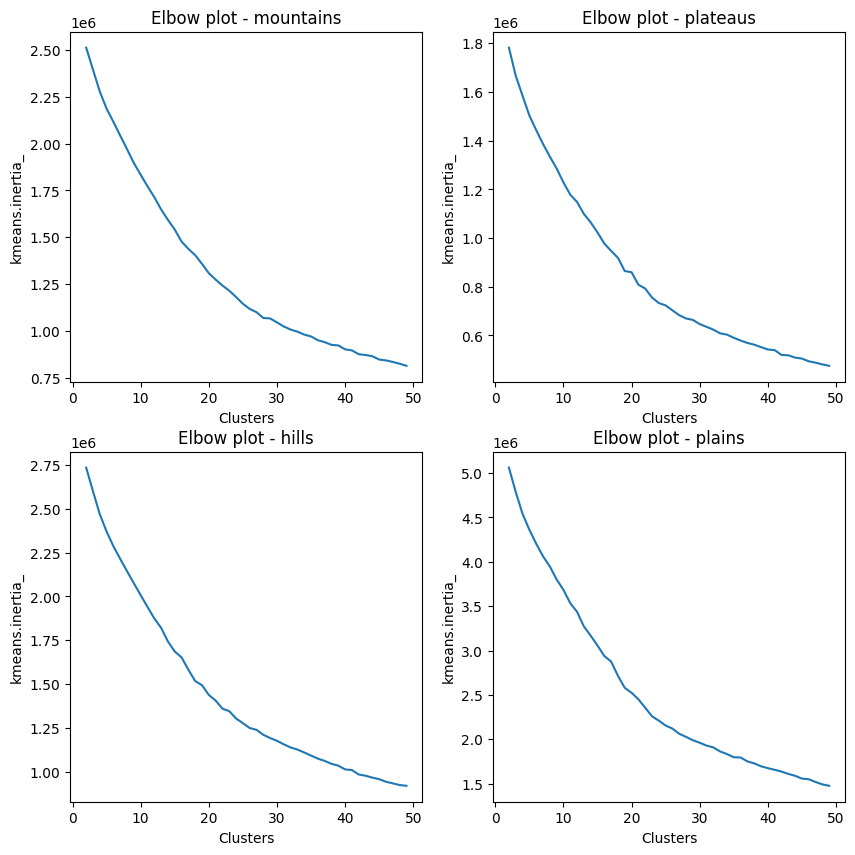

In [19]:
# Elbow plot
fig,axs = plt.subplots(2,2,figsize=(10,10))
axs = axs.flatten()
for inertia,landform,ax in zip(inertias,landforms,axs):
    ax.plot(n_clusters_range,inertia)
    ax.set_xlabel('Clusters')
    ax.set_ylabel('kmeans.inertia_')
    ax.set_title(f'Elbow plot - {landform}');

### Visualize clustering outcomes

In [35]:
cluster_path = Path('/Users/wmk934/data/perceptual_models/data/clustering')

In [22]:
image_path = Path('/Users/wmk934/data/perceptual_models/img/cluster_maps/')

In [21]:
# Get some borders for context
border_path = Path('/Users/wmk934/data/Global_geospatial/borders/world-administrative-boundaries')
border_file = 'world-administrative-boundaries.shp'
borders = gpd.read_file(border_path/border_file)
nab = borders[(borders['iso3'] == 'USA') | (borders['iso3'] == 'CAN') | (borders['iso3'] == 'MEX')].copy().reset_index(drop=True)

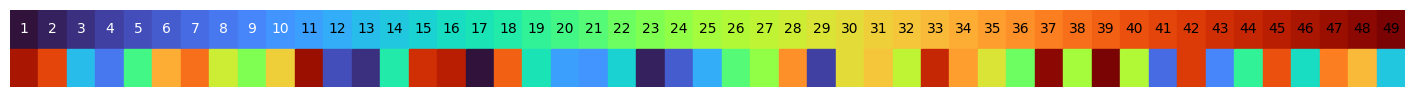

In [100]:
# Create a custom color map for values
num_colors = 49

# Generate a list of evenly spaced values from 0 to 1
values = np.linspace(0, 1, num_colors)

# Create a colormap using these values
colors_norm = plt.cm.turbo(values)
colors_shuf = plt.cm.turbo(values)
np.random.shuffle(colors_shuf)

# Plot the colormap
fig, ax = plt.subplots(figsize=(18, 1))
for i, (color_n,color_s) in enumerate(zip(colors_norm,colors_shuf)):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color_n))
    ax.add_patch(plt.Rectangle((i, -1), 1, 1, color=color_s))
    tcolor = 'black'
    if i < 10: tcolor = 'white'
    ax.text(i + 0.5, 0.5, str(i + 1), ha='center', va='center', color=tcolor)

ax.set_xlim(0, num_colors)
ax.set_ylim(-1, 1)
ax.set_axis_off()
plt.show()

In [ ]:
for landform in landforms:
    
    # Load data
    cluster_file = f'clustering_results_{landform}_clusters_2_to_50.shp'
    gdf = gpd.read_file(cluster_path / landform / cluster_file)

    # Make output folder
    img_folder = image_path / landform
    img_folder.mkdir(exist_ok=True, parents=True)

    # Loop over the clusters
    for cluster in n_clusters_range:
        column = f'cluster_{cluster}'
        cmap = mcolors.ListedColormap(colors_shuf[0:cluster])
        
        fig,ax = plt.subplots(1,1,figsize=(10,10))
        
        nab.plot(ax=ax, color='0.66')
        gdf.plot(ax=ax, column=column, cmap=cmap, legend=True, legend_kwds={'shrink':0.8})
        
        ax.set_xlim([-180,-45])
        ax.set_title(f'{landform}, {cluster} clusters')

        cbar = ax.get_figure().get_axes()[1]  # Assuming colorbar is the second axes
        cbar.set_yticklabels([])  # Disable tick labels
        cbar.set_yticks([])  # Disable tick marks - we need to do this so that the axis don't get shifted around between different n_cluster values, in case where the colorbar ticks change
     
        img_file = f'clustering_outcomes_{landform}_{cluster:02}.png'
        plt.savefig(img_folder/img_file, dpi=300, bbox_inches='tight')
        plt.close()